<a href="https://colab.research.google.com/github/Luseat/Prediksi-IHSG/blob/main/forecasting_IHSG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error
import yfinance as yf
import seaborn as sns
import matplotlib.dates as mdates

**Import Data IHSG**

In [3]:
start_date = "2017-01-01"
end_date = "2025-03-29"

data = yf.Ticker("^JKSE")
data = data.history(start=start_date, end=end_date)
del data['Dividends']
del data['Stock Splits']
forcaseData = data.copy()
data.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2025-03-21 00:00:00+07:00,6418.390137,6426.165039,6218.601074,6258.179199,190225100
2025-03-24 00:00:00+07:00,6242.234863,6269.903809,5967.193848,6161.217773,124187900
2025-03-25 00:00:00+07:00,6197.986816,6265.295898,6178.490234,6235.619141,111267000
2025-03-26 00:00:00+07:00,6314.329102,6489.148926,6312.966797,6472.355957,159762700
2025-03-27 00:00:00+07:00,6462.596191,6510.620117,6417.240234,6510.620117,121855500


**Penutupan harga indeks IHSG**

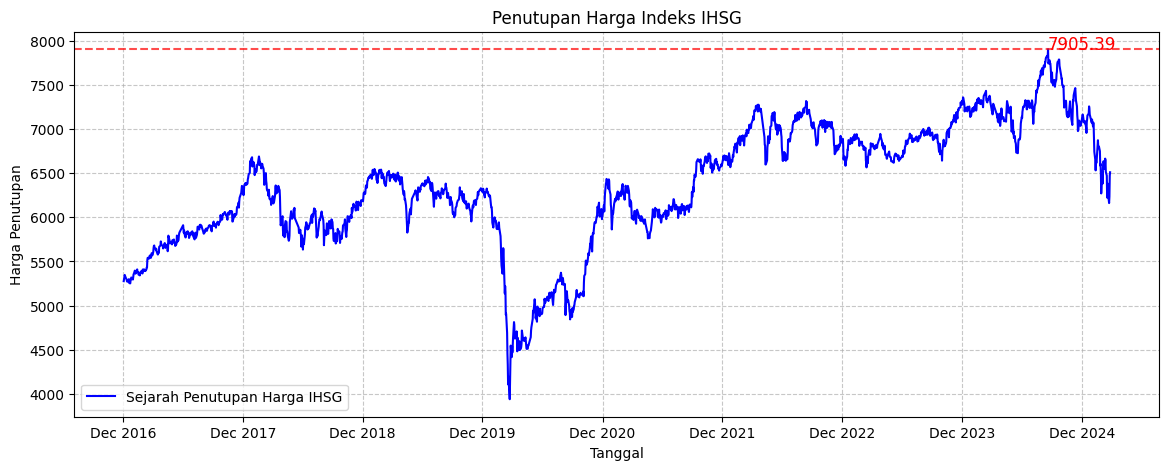

In [10]:
plt.figure(figsize=(14, 5))
sns.lineplot(data=data, x=data.index, y='Close', label='Sejarah Penutupan Harga IHSG', color='blue')

max_price = data['Close'].max()
max_price_date = data['Close'].idxmax()

#Annotate the Highest price
plt.annotate(f'{max_price:.2f}',
             xy=(max_price_date, max_price),
             xytext=(max_price_date, max_price + 2),
             fontsize=12, color='red')

plt.axhline(max_price, linestyle='--', color='red', alpha=0.7)
plt.title('Penutupan Harga Indeks IHSG')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

**Preprocessing**

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
scaled_data

array([[0.33730361],
       [0.34365781],
       [0.34978741],
       ...,
       [0.57916512],
       [0.63883025],
       [0.64847402]])

In [12]:
def create_sequences(data, sequence_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        labels.append(data[i:i + sequence_length, 0])
    return np.array(sequences), np.array(labels)

In [13]:
sequence_length = 60

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

**Training Data (LSTM)**

In [ ]:
model = Sequential()

